In [1]:
setwd("/projects/CARDIPS/analysis/epigenome_resource")
source("analyses/jennifer/notebooks/functions.R")

set.seed(5366)

# Figure 5b: Which QTL type is most enriched for GWAS colocalization? 

## read supplemental table for GWAS colocalizations

In [3]:
## Supplemental table with GWAS colocalization
gwas_coloc = fread("analyses/tim/gwas_coloc/tables/Table_SX_GWAS_Colocalizations_2024_0911.txt", data.table = F)
colnames(gwas_coloc) = gsub(" ","_",colnames(gwas_coloc))
gwas_coloc = gwas_coloc %>%      mutate(GWAS_ID = paste(Trait_Description, GWAS_Index),
                                        Cluster_GWAS = paste(Cluster_ID, Trait_Description))

nrow(gwas_coloc)
head(gwas_coloc,2)

[1] 454388

,Tissue,Trait_Description,Trait_ID,Cluster_ID,QTL_Combination,Complexity,Element_ID,Condition,Element_Name,Element_Chrom,⋯,Beta.GWAS,SE.GWAS,Pvalue.GWAS,99Credible_Set_Size,Colocalized,GWAS_Index,Element_Cond,GWAS_QTL_Combination_Collapse,GWAS_ID,Cluster_GWAS
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<int>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>
1,CVPC,Aging,timmers2020_healthspan_lifespan_longevity,CVPC_100,caQTL-eQTL,Complex,ENSG00000287315.1,0,ENSG00000287315,chr1,⋯,0.002339,0.001729,1.76198e-01,11,FALSE,No Colocalization,ENSG00000287315.1_0,No Colocalization,Aging No Colocalization,CVPC_100 Aging
2,CVPC,Aging,timmers2020_healthspan_lifespan_longevity,CVPC_1003,caQTL-eQTL,Complex,ENSG00000137474.23,0,MYO7A,chr11,⋯,0.008016,0.001994,5.84166e-05,3551,FALSE,No Colocalization,ENSG00000137474.23_0,No Colocalization,Aging No Colocalization,CVPC_1003 Aging


In [4]:
length(unique(gwas_coloc$Trait_Description))

[1] 15

In [5]:
a = gwas_coloc %>% filter(duplicated(Cluster_GWAS))

if (nrow(a) > 0)
{
    message("Error: Some clusters have multiple nominated QTLs")
}

## prepare data for fisher test input

In [6]:
colnames(gwas_coloc)

[1] "Tissue"                           "Trait_Description"               
 [3] "Trait_ID"                         "Cluster_ID"                      
 [5] "QTL_Combination"                  "Complexity"                      
 [7] "Element_ID"                       "Condition"                       
 [9] "Element_Name"                     "Element_Chrom"                   
[11] "Element_Start"                    "Element_End"                     
[13] "Nsnps"                            "PP.H0"                           
[15] "PP.H1"                            "PP.H2"                           
[17] "PP.H3"                            "PP.H4"                           
[19] "Max_Hypothesis_PP"                "Likely_Colocalization_Hypothesis"
[21] "Top_SNP_ID"                       "Top_SNP_PP"                      
[23] "Beta.QTL"                         "SE.QTL"                          
[25] "Pvalue.QTL"                       "Beta.GWAS"                       
[27] "SE.GWAS"                          "Pvalue.GWAS"                     
[29] "99Credible_Set_Size"              "Colocalized"                     
[31] "GWAS_Index"                       "Element_Cond"                    
[33] "GWAS_QTL_Combination_Collapse"    "GWAS_ID"                         
[35] "Cluster_GWAS"

In [7]:
gwas_coloc2 = gwas_coloc %>% 
#     dplyr::rename(Cluster_ID = cluster_id, QTL_Combination = qtl_combo, Membership = module) %>%
    select(Cluster_ID, QTL_Combination,  Complexity)  %>%
    distinct()

gwas_coloc2$Colocalized = ifelse(gwas_coloc2$Cluster_ID %in% gwas_coloc[gwas_coloc$Colocalized == T,]$Cluster_ID, T, F)

table(gwas_coloc2$Colocalized)

head(gwas_coloc2,2)


FALSE  TRUE 
51510   695 

,Cluster_ID,QTL_Combination,Complexity,Colocalized
,<chr>,<chr>,<chr>,<lgl>
1,CVPC_100,caQTL-eQTL,Complex,FALSE
2,CVPC_1003,caQTL-eQTL,Complex,FALSE


## how many clusters per QTL combination

In [8]:
table(gwas_coloc2$QTL_Combination)


           caQTL       caQTL-eQTL caQTL-eQTL-haQTL      caQTL-haQTL 
           25455             1459              343             1720 
            eQTL       eQTL-haQTL            haQTL 
           15829              391             7008 

## check that there are no duplicate QTL clusters

In [9]:
gwas_coloc2 %>% filter(duplicated(Cluster_ID))

Cluster_ID,QTL_Combination,Complexity,Colocalized
<chr>,<chr>,<chr>,<lgl>


## annotate cluster with singleton or module

In [10]:
# annotate each cluster by:
# 1. whether the cluster was a module or a singleton 
# 2. their molecular phenotypes as well

gwas_coloc3 = gwas_coloc2 %>% mutate(QTL_Combination = paste(Complexity, QTL_Combination))

unique(gwas_coloc3$QTL_Combination)


[1] "Complex caQTL-eQTL"       "Complex eQTL"            
 [3] "Singleton caQTL"          "Complex eQTL-haQTL"      
 [5] "Complex caQTL-haQTL"      "Complex haQTL"           
 [7] "Complex caQTL-eQTL-haQTL" "Complex caQTL"           
 [9] "Singleton haQTL"          "Singleton eQTL"

In [11]:
head(gwas_coloc3,2)

,Cluster_ID,QTL_Combination,Complexity,Colocalized
,<chr>,<chr>,<chr>,<lgl>
1,CVPC_100,Complex caQTL-eQTL,Complex,FALSE
2,CVPC_1003,Complex caQTL-eQTL,Complex,FALSE


## add QTL modules / singletons that did not meet the 50 variant criteria for overlapping GWAS, they are annotated as not colocalized

In [12]:
substrRight <- function(x, n){
  substr(x, nchar(x)-n+1, nchar(x))
}

In [13]:

mods = fread("analyses/tim/ld_modules/modules/all_modules_091124.txt",sep="\t",data.table=F)
mods$tissue_element = paste(mods$Tissue, mods$`Element ID`, sep="_")

message(paste("# clusters total:", length(unique(mods$Cluster_ID))))

# mods %>% filter(nominated == T) %>% filter(duplicated(`Cluster ID`))

# clusters total: 52374



In [14]:
message(paste("Need to add other clusters:", length(unique(mods[!mods$Cluster_ID %in% gwas_coloc3$Cluster_ID,]$Cluster_ID))))

Need to add other clusters: 169



In [16]:
mods2 = mods %>% 
    filter(!mods$Cluster_ID %in% gwas_coloc3$Cluster_ID) %>%
    filter(Nominated == T) %>% 
    mutate(QTL_Combination = qtl_combo, 
           Colocalized = F) %>%
    mutate(QTL_Combination = gsub("eGene", "eQTL", QTL_Combination)) %>%
    mutate(QTL_Combination = gsub("haPeak", "haQTL", QTL_Combination)) %>%
    mutate(QTL_Combination = gsub("caPeak", "caQTL", QTL_Combination)) %>%
    select(Cluster_ID, QTL_Combination, Colocalized, Complexity) %>%
    mutate(QTL_Combination = paste(Complexity, QTL_Combination)) %>%
    distinct()

length(unique(mods2$Cluster_ID))

[1] 169

In [17]:
table(mods2$QTL_Combination)


           Complex caQTL       Complex caQTL-eQTL Complex caQTL-eQTL-haQTL 
                      14                       11                        3 
     Complex caQTL-haQTL       Complex eQTL-haQTL            Complex haQTL 
                       5                        5                        4 
         Singleton caQTL           Singleton eQTL          Singleton haQTL 
                      86                       17                       24 

In [18]:
table(mods2$Complexity )



  Complex Singleton 
       42       127 

In [19]:
gwas_coloc4 = rbind(gwas_coloc3, mods2) %>% distinct()

In [20]:
table(gwas_coloc4$Complexity)



  Complex Singleton 
     5672     46702 

In [21]:
length(unique(gwas_coloc4$Cluster_ID))

gwas_coloc4 %>% filter(duplicated(Cluster_ID))

[1] 52374

Cluster_ID,QTL_Combination,Complexity,Colocalized
<chr>,<chr>,<chr>,<lgl>


In [22]:
gwas_coloc4$tissue = unlist(lapply(gwas_coloc4$Cluster_ID, function(x) { unlist(strsplit(x, "_"))[1] }))

In [23]:
table(gwas_coloc4$tissue)


 CVPC  iPSC   PPC 
20623 17370 14381 

In [24]:
gwas_coloc4$QTL_Combination = gsub(",","-",gwas_coloc4$QTL_Combination)
gwas_coloc4$QTL_Combination = gsub("caPeak","caQTL",gwas_coloc4$QTL_Combination)
gwas_coloc4$QTL_Combination = gsub("haPeak","haQTL",gwas_coloc4$QTL_Combination)
gwas_coloc4$QTL_Combination = gsub("eGene","eQTL",gwas_coloc4$QTL_Combination)



table(gwas_coloc4$QTL_Combination)


           Complex caQTL       Complex caQTL-eQTL Complex caQTL-eQTL-haQTL 
                     749                     1470                      346 
     Complex caQTL-haQTL             Complex eQTL       Complex eQTL-haQTL 
                    1725                      703                      396 
           Complex haQTL          Singleton caQTL           Singleton eQTL 
                     283                    24806                    15143 
         Singleton haQTL 
                    6753 

## **test for GWAS enrichment for each tissue and all tissues**

In [25]:
tests = as.data.frame(rbindlist(lapply(unique(gwas_coloc4$QTL_Combination), function(combo)
{
    as.data.frame(rbindlist(lapply(c("CVPC", "iPSC", "PPC", "All tissues"), function(tiss)
    {
        if (tiss %like% "All")
        {
            this = gwas_coloc4 
        } else
        {
            this = gwas_coloc4 %>% filter(tissue == tiss)
        }

        # annotation 1: Which cluster has the QTL combination label?
        this2 = this %>% mutate(in_cluster = ifelse(QTL_Combination == combo, T, F))

        # annotation 2: Which cluster colocalized with at least one GWAS trait (already done)

        # fisher test
        if (length(unique(this2$in_cluster)) == 2 & length(unique(this2$Colocalized)) == 2)
        {
            test = fisher.test(table(this2$Colocalized, this2$in_cluster))
            f1 = length(unique(this2[this2$in_cluster == T & this2$Colocalized == T,]$Cluster_ID)) / length(unique(this2[this2$in_cluster == T,]$Cluster_ID)) * 100
            f2 = length(unique(this2[this2$in_cluster == F & this2$Colocalized == T,]$Cluster_ID)) / length(unique(this2[this2$in_cluster == F,]$Cluster_ID)) * 100

            # out
            data.frame(qtl_combo = combo, 
                       tissue = tiss,
                       estimate = test$estimate, 
                       pval = test$p.value, 
                       ci1 = test$conf.int[1], 
                       ci2 = test$conf.int[2], 
                       in_frac = f1, 
                       ot_frac = f2)
        }
    })))
        
}))) %>% arrange(desc(estimate)) %>% mutate(qval = p.adjust(pval, "BH"))  

tests$logci1 = log2(tests$ci1)
tests$logci2 = log2(tests$ci2)
tests$is_sig = ifelse(tests$pval <= 0.05 & (tests$logci1 * tests$logci2) > 0 & !is.infinite(tests$logci1) & !is.infinite(tests$logci2), T, F)


In [28]:
fwrite(tests,"~/projects/Resource/notebooks/toGitHub/sourcedata/SOURCEDATA.FIGURE5B.txt",sep="\t",row.names=F,quote=F)

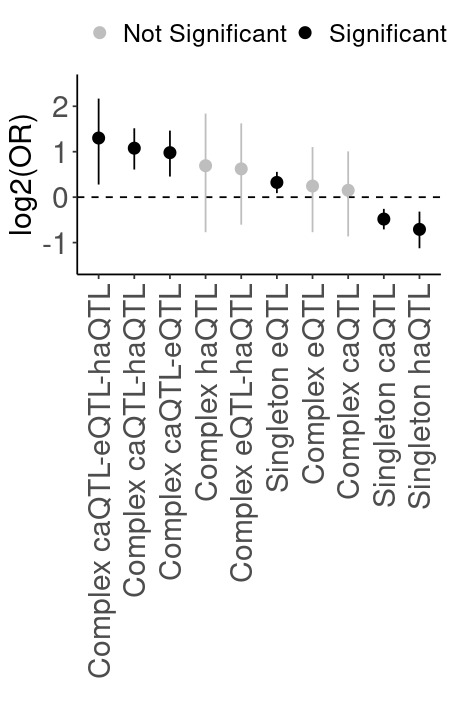

In [26]:
# plot "all" only
psize(w = 7.5, h = 8)
toplot = tests
order = tests %>% filter(tissue %like% "All") %>% arrange(log2(estimate))
order = rev(order$qtl_combo)
toplot$qtl_combo = factor(toplot$qtl_combo, levels = order)
toplot$is_sig = ifelse(toplot$is_sig == F, "Not Significant", "Significant")
# toplot$is_sig = factor(toplot$is_sig, levels = c("Significant","Not Significant"))
psize(3.75,6)
# png("~/projects/Resource/notebooks/toGitHub/figures/figure5b_v2.png", res =300, units ="in", height =6,width=3.75)
ggplot(toplot %>% filter(tissue %like% "All"), aes(x = qtl_combo, y = log2(estimate), color = is_sig)) + 
    geom_point(size = 3) + 
#     facet_wrap(.~tissue, nrow = 1, scales = "free_x") + 
    jn_classic + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5),
          strip.text = element_text(size = 12),
          legend.position = "top"
         ) + 
    geom_hline(yintercept = 0, linetype = "dashed") + 
    xlab("") + ylim(-1.5, 2.5) + 
    scale_color_manual(values = c("gray", "black"), name = "") +
    geom_segment(data = toplot %>% filter(tissue %like% "All" & is_sig == "Not Significant"), aes(x = qtl_combo, xend = qtl_combo, y = logci1, yend = logci2), color = "grey") + 
    geom_segment(data = toplot %>% filter(tissue %like% "All" & is_sig == "Significant"), aes(x = qtl_combo, xend = qtl_combo, y = logci1, yend = logci2), color = "black")  + 
    ylab("log2(OR)")
# dev.off()

In [177]:
# plot all tissues
png("~/projects/Resource/notebooks/toGitHub/figures/suppgwasenrich_v2.png",
   units="in",res=300,height=5,width=7)
psize(w = 7, h = 5)
toplot = tests[ tests$tissue != "All tissues",]
toplot$qtl_combo = gsub("Module","Complex",toplot$qtl_combo)
order = tests %>% filter(tissue %like% "All") %>% arrange(log2(estimate))
order2 = gsub("Module","Complex",rev(order$qtl_combo))
toplot$qtl_combo = factor(toplot$qtl_combo, levels = order2)
toplot$tissue = factor(toplot$tissue, levels = c("iPSC","CVPC","PPC"))
toplot$logci1[ toplot$logci1 < -3 ] =-3
toplot$logci2[ toplot$logci2 > 3 ] =3
toplot$is_sig = ifelse(toplot$is_sig == F, "Not Significant", "Significant")
ggplot(toplot, aes(x = qtl_combo, y = log2(estimate), color = is_sig)) + 
    geom_point(size = 3) + 
    facet_wrap(.~tissue, nrow = 1, scales = "free_x") + 
    theme_bw2 + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5),
          strip.text = element_text(size = 10), legend.title=element_blank()) + 
    geom_hline(yintercept = 0, linetype = "dashed") + 
    xlab("") + ylim(-3,3) + 
    scale_color_manual(values = c("gray", "black")) +
    geom_segment(data = toplot %>% filter(is_sig == "Not Significant"), aes(x = qtl_combo, xend = qtl_combo, y = logci1, yend = logci2), color = "grey") + 
    geom_segment(data = toplot %>% filter(is_sig == "Significant"), aes(x = qtl_combo, xend = qtl_combo, y = logci1, yend = logci2), color = "black") +
    ylab("log2(OR)") 
dev.off()

png 
  2